In [1]:
import os
import sys
sys.path.append('/home/brandon/Documents/DeepChatModels')
from imp import reload
import data
import json
import pandas as pd
from pprint import pprint
import sys
reload(data)
from data.reddit_preprocessor import remove_extra_columns

Using logfile: /tmp/data_helpermubile0x
Hi, I'm a DataHelper. For now, I help with the reddit dataset.
At any prompt, press ENTER if you want the default value.
Username (default='brandon'): 
Hello, brandon, I've set your data root to /home/brandon/Datasets/reddit
Years to process (default='2007,2008,2009'): 
These are the files I found:
['/home/brandon/Datasets/reddit/raw_data/2007/RC_2007-11',
 '/home/brandon/Datasets/reddit/raw_data/2007/RC_2007-12',
 '/home/brandon/Datasets/reddit/raw_data/2007/RC_2007-10',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-12',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-07',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-08',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-03',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-06',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-05',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-09',
 '/home/brandon/Datasets/reddit/raw_data/2008/RC_2008-01',
 '/home/bra

In [6]:
from data import DataHelper


In [3]:
PROJECT_ROOT = '/home/brandon/Documents/DeepChatModels'
REDDIT_DIR = '/home/brandon/Datasets/reddit'
SOURCE_DIR = os.path.join(REDDIT_DIR, 'raw_data')
TARGET_DIR = os.path.join(REDDIT_DIR, 'raw_data_columns_removed')
print(TARGET_DIR)
YEAR = '2009'
TARGET_FILE = os.path.join(TARGET_DIR, YEAR + '_cols_removed.json')

/home/brandon/Datasets/reddit/raw_data_columns_removed


In [ ]:
data_helper = DataHelper()

In [ ]:
data_helper.file_counter = 9
print(data_helper.file_paths[data_helper.file_counter:])

## Load 2007 Data in DF

In [ ]:
df = data_helper.safe_load()

In [ ]:
print("df has {} rows.".format(len(df.index)))
print("df has columns:\n", df.columns)
df.body.head()

In [ ]:
df = remove_extra_columns(df)

In [ ]:
print("df has {} rows.".format(len(df.index)))
print("df has columns:\n", df.columns)
df.head()

In [ ]:
DataHelper.df_to_json(df, orient='records', lines=False, target_file=TARGET_FILE)

## In One Function

In [ ]:
def remove_extra_columns_and_save()
    print("Removing extra columns . . . ")
    df = remove_extra_columns(df)
    print("Saving to {} . . . ".format(TARGET_FILE))
    DataHelper.df_to_json(
        df, 
        orient='records', 
        lines=False, 
        target_file=TARGET_FILE)
    print("Done!")

### Loading back later

In [ ]:
df_loaded = pd.read_json(target_file)

In [ ]:
len(df_loaded)

In [ ]:
file_names = []
for y in ['2007', '2008', '2009']:
    file_names.append(y + '_cols_removed.json')
file_names = file_names[:-1]
#file_names[-1] = '2009_cols_removed_part_1.json'
#file_names.append('2009_cols_removed_part_2.json')
file_names = [os.path.join(TARGET_DIR, fname) for fname in file_names]
pprint(file_names)

In [ ]:
list_ = []
for file_path in file_names:
    print('file:', file_path)
    sys.stdout.flush()
    list_.append(pd.read_json(file_path))
df = pd.concat(list_).reset_index()
del list_
list_ = None

In [ ]:
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_cols_removed.json')
DataHelper.df_to_json(df, orient='records', lines=False, target_file=TARGET_FILE)

# Stage 2: Regex, Long Comments, and Contractions

### Regex

In [ ]:
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_cols_removed.json')
df = pd.read_json(TARGET_FILE)
print('DataFrame loaded.')

In [ ]:
from data.reddit_preprocessor import regex_replacements
df = regex_replacements(df)
print('Regex replacements done.')

In [ ]:
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_regex_replaced.json')
DataHelper.df_to_json(df, orient='records', lines=False, target_file=TARGET_FILE)

### Long Comments

In [ ]:
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_regex_replaced.json')
df = pd.read_json(TARGET_FILE)
print('DataFrame loaded from', TARGET_FILE)

In [ ]:
reload(data)
from data.reddit_preprocessor import remove_large_comments, expand_contractions
df = remove_large_comments(df=df, max_len=20)
df = expand_contractions(df)
print('Remove large comments and contractions done.')

In [ ]:
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_large_comments_contractions.json')
DataHelper.df_to_json(df, orient='records', lines=False, target_file=TARGET_FILE)

In [ ]:
print('done')

# Stage 3: Parallel Calls

In [4]:
from data.reddit_preprocessor import parallel_map_list
from data.reddit_preprocessor import data_helper
TARGET_FILE = os.path.join(TARGET_DIR, '2007-8_large_comments_contractions.json')
df = pd.read_json(TARGET_FILE)
print('DataFrame loaded from', TARGET_FILE)

DataFrame loaded from /home/brandon/Datasets/reddit/raw_data_columns_removed/2007-8_large_comments_contractions.json


In [7]:
from collections import Counter
from itertools import chain
sentences = parallel_map_list(fn=DataHelper.word_tokenizer, iterable=df.body.values)
data_helper.set_word_freq(Counter(chain.from_iterable(sentences)))

Time to run parallel_map_list: 19.272 seconds.


In [8]:
from data.reddit_preprocessor import sentence_score
df['score'] = parallel_map_list(fn=sentence_score, iterable=sentences)
del sentences

Time to run parallel_map_list: 215.748 seconds.


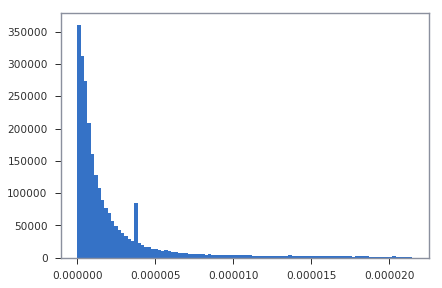

In [23]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style('onedork')
jtplot.style(ticks=True, grid=False)
jtplot.figsize(aspect=1.2)
plt.hist(df['score'].values, bins=100,
        range=(0., df['score'].quantile(0.7)))
plt.show()

# Final Stage

In [25]:
# Keep the desired percentage of lowest-scored sentences. (low == good)
from data.reddit_preprocessor import children_dict
keep_best_percent = 0.7
df = df.loc[df['score'] < df['score'].quantile(keep_best_percent)]

print('Prepping for the grand finale.')
comments_dict = pd.Series(df.body.values, index=df.name).to_dict()
root_to_children = children_dict(df)
data_helper.generate_files(
            from_file_path="from_file.txt",
            to_file_path="to_file.txt",
            root_to_children=root_to_children,
            comments_dict=comments_dict)

Prepping for the grand finale.
Time to run children_dict: 4.701 seconds.
Final processed file has 306164 samples total.


# Exploration

In [ ]:
df.style.set_properties(subset=['text'], **{'width': '800px'})
def get_comments(df, n=10):
    i = 0
    while i < len(df.index):
        yield df.loc[i:i+n]['body']
        i += n

In [ ]:
gen = get_comments(df, 5)

In [ ]:
comments = next(gen)
for comment in comments:
    print(comment)